### 2.3 Hierarchical clustering of bird species

Learning goal: Hierarchical clustering and evaluation of results

In file birdspecies.csv you can find data on 64 Finnish birds species that live near watersides. You can find a link to the data and its description in MyCourses. There are three numerical and two categorical features that will be used for clustering and a class variable that tells the biological group of the species

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from math import *

(a) Feature extraction: Create two new variables, $BMI$ and $WSI$, from length, wspan and weight. Body-mass index $\text{BMI = weight/length}^2$ describes how thin the bird is and wing span index $\text{WSI = wspan/length}$ how long wings it has. (See description how to treat the range-valued features.)

In [3]:
import pandas as pd

# Load the dataset
df = pd.read_csv('birdspecies.csv', delimiter=';')

# Extract mid values for range-valued features
df['length_mid'] = df['length'].apply(lambda x: (float(x.split('-')[0]) + float(x.split('-')[1])) / 2)
df['wspan_mid'] = df['wspan'].apply(lambda x: (float(x.split('-')[0]) + float(x.split('-')[1])) / 2)
df['weight_mid'] = df['weight'].apply(lambda x: (float(x.split('-')[0]) + float(x.split('-')[1])) / 2)

# Calculate BMI and WSI
df['BMI'] = df['weight_mid'] / (df['length_mid'] ** 2)
df['WSI'] = df['wspan_mid'] / df['length_mid']

# Display the DataFrame with new features
print(df[['species', 'BMI', 'WSI']])

# Save the df
df[['species', 'BMI', 'WSI']].to_csv('birdspecies_BMI_WSI.csv', sep=';', index=False)


          species       BMI       WSI
0      pikkulokki  0.184911  2.519231
1      naurulokki  0.212191  2.569444
2       kalalokki  0.240930  2.464286
3      selkälokki  0.239158  2.241071
4     harmaalokki  0.291667  2.258333
..            ...       ...       ...
59    meriharakka  0.261286  1.867470
60  kaulushaikara  0.240000  1.533333
61  harmaahaikara  0.115235  1.736842
62   kattohaikara  0.281233  1.837209
63    jalohaikara  0.128561  1.702703

[64 rows x 3 columns]


(b) Pairwise distances: 

- (i) Calculate pairwise Euclidean distances using only the new numerical features BMI and WSI. 

In [4]:
def L2dist_func(r1,r2):
	L2dist_matrix = np.zeros((len(r1),len(r2))); 
	for i in range(len(r1)):
		for j in range(len(r2)):
			BMI1 = r1[i]
			BMI2 = r1[j]
			WSI1 = r2[i]
			WSI2 = r2[j]
			distance = sqrt((BMI1-BMI2)**2 + (WSI1-WSI2)**2)
			L2dist_matrix[i, j] = distance

	return L2dist_matrix

L2dist = L2dist_func(df['BMI'].to_numpy(),df['WSI'].to_numpy());

# There are 64 bird species so the matrix should be 64x64
print("Shape:", L2dist.shape)

print("\nThe Euclidean pairwise distance of the birds based on BMI and WSI\n")
print(L2dist)

Shape: (64, 64)

The Euclidean pairwise distance of the birds based on BMI and WSI

[[0.         0.05714558 0.07846673 ... 0.78548503 0.68878965 0.81847018]
 [0.05714558 0.         0.10901491 ... 0.83822855 0.73548288 0.87076707]
 [0.07846673 0.10901491 0.         ... 0.73822303 0.62837027 0.76982817]
 ...
 [0.78548503 0.83822855 0.73822303 ... 0.         0.19398142 0.0366479 ]
 [0.68878965 0.73548288 0.62837027 ... 0.19398142 0.         0.20347186]
 [0.81847018 0.87076707 0.76982817 ... 0.0366479  0.20347186 0.        ]]


- (ii) Calculate pairwise overlap distances using only the categorical features (back and belly). The overlap similarity is described in slides of lecture 2, but now we will need distance, i.e., $d_{OL} = 1 − \frac{1}{2} \sum^7_{i=6} s(\textbf{x}_i, \textbf{y}_i)$, where

$$s(xi, yi) = 
   \begin{cases} 
     1 & \text{if } x_i = y_i \\
     0 & \text{otherwise  } 
    \end{cases}   
$$


In [5]:
def overlapdist_func(r1,r2):
	overlap_dist_matrix = np.zeros((len(r1),len(r2)));
	for i in range(len(r1)):
		for j in range(len(r2)):
			overlap = 0.0
			back1 = r1[i]
			back2 = r1[j]
			belly1 = r2[i]
			belly2 = r2[j]

			if back1 == back2:
				overlap += 1
			if belly1 == belly2:
				overlap += 1
			#print(overlap)
			distance = 1 - (1/2) * overlap
			overlap_dist_matrix[i, j] = distance
	return overlap_dist_matrix

overlap_dist = overlapdist_func(df['back'].to_numpy(),df['belly'].to_numpy());

# There are 64 bird species so the matrix should be 64x64
print("Shape:", overlap_dist.shape)

print("\nThe overlapping distance of the birds based on back and belly\n")
print(overlap_dist)

Shape: (64, 64)

The overlapping distance of the birds based on back and belly

[[0.  0.  0.5 ... 0.5 0.5 0.5]
 [0.  0.  0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.  ... 1.  0.5 0.5]
 ...
 [0.5 0.5 1.  ... 0.  1.  1. ]
 [0.5 0.5 0.5 ... 1.  0.  0.5]
 [0.5 0.5 0.5 ... 1.  0.5 0. ]]


- (iii) Combine the distances as in Task 1.1, but experiment to find good weight $\lambda$ (suggestion: try $\lambda > 0.5$, since otherwise the categorical distances will dominate too much). You can find a Python implementation of the distance calculation (combdist.py) in MyCourses.

In [6]:
def combined_distance(L2dist, overlap_dist, lamb):
    L2dist_std = L2dist.std()
    print(L2dist)
    print(L2dist_std)
    overlap_dist_std = overlap_dist.std()
    print(overlap_dist_std)
    combined_dist_matrix = lamb * (L2dist / L2dist_std) + (1 - lamb) * (overlap_dist / overlap_dist_std)
    return combined_dist_matrix

combined_dist = combined_distance(L2dist, overlap_dist, 0.75)

print("\nThe combined distance of the birds based on BMI, WSI, back and belly\n")
print(combined_dist)


[[0.         0.05714558 0.07846673 ... 0.78548503 0.68878965 0.81847018]
 [0.05714558 0.         0.10901491 ... 0.83822855 0.73548288 0.87076707]
 [0.07846673 0.10901491 0.         ... 0.73822303 0.62837027 0.76982817]
 ...
 [0.78548503 0.83822855 0.73822303 ... 0.         0.19398142 0.0366479 ]
 [0.68878965 0.73548288 0.62837027 ... 0.19398142 0.         0.20347186]
 [0.81847018 0.87076707 0.76982817 ... 0.0366479  0.20347186 0.        ]]
0.25635951645958005
0.29036891688832234

The combined distance of the birds based on BMI, WSI, back and belly

[[0.         0.16718392 0.66004745 ... 2.72848531 2.44559534 2.82498596]
 [0.16718392 0.         0.74941858 ... 2.88279063 2.58220006 2.97798463]
 [0.66004745 0.74941858 0.         ... 3.02070345 2.26883366 2.68267992]
 ...
 [2.72848531 2.88279063 3.02070345 ... 0.         1.42848165 0.96819003]
 [2.44559534 2.58220006 2.26883366 ... 1.42848165 0.         1.02575983]
 [2.82498596 2.97798463 2.68267992 ... 0.96819003 1.02575983 0.        ]]


(c) Cluster the data with agglomerative hierarchical clustering using the combined pairwise distance. Try at least complete and average linkage and different values of clusters, $K = 5,..., 20$. Choose the best clustering with the normalized mutual information $NMI$ by Strehl and Ghosh (see slides of lecture 5)

In [10]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import normalized_mutual_info_score

# Load the data
data = pd.read_csv("birdspecies.csv", delimiter=";")

# Assuming you've already calculated the combined pairwise distance matrix as `combined_distance_matrix`
# and the true labels are in a column named 'group'

best_nmi = -1
best_k = 0
best_linkage = None

for method in ['complete', 'average']:
    Z = linkage(combined_dist, method=method)
    for k in range(5, 21):
        labels = fcluster(Z, k, criterion='maxclust')
        nmi = normalized_mutual_info_score(data['group'], labels)
        if nmi > best_nmi:
            best_nmi = nmi
            best_k = k
            best_linkage = method

print(f"Best NMI: {best_nmi}")
print(f"Best number of clusters (K): {best_k}")
print(f"Best linkage method: {best_linkage}")


Best NMI: 0.6751144686490355
Best number of clusters (K): 20
Best linkage method: complete


C:\Users\springnuance\AppData\Local\Temp\ipykernel_24872\1755534669.py:17: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(combined_dist, method=method)
C:\Users\springnuance\AppData\Local\Temp\ipykernel_24872\1755534669.py:17: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(combined_dist, method=method)


(d) What is your opinion, how well does the clustering match the biological grouping? Are there differences between the biological groups, how easily they can be detected by clusters? You can find more information on the hierarchy of the biological groups in the description. Plotting a dendrogram is optional but will help in the interpretation

Taxonomy
1. Charadriiformes (shorebirds)
- 1.1 Lari
- 1.1.1 Laridae (lokit, gulls)
- 1.1.2 Sternidae (tiirat, terns)

- 1.2 Charadrii (kahlaajat, waders)
- 1.2.1 Scolopacidae (kurpat, sandpipers etc)
- 1.2.2 Charadriidae (kurmitsat, plovers etc)
- 1.2.3 Haematopodidae (meriharakat, oystercatchers)

2. Anatidae (ducks, geese, swans)
- 2.1 Anatinae (varsinaiset sorsat, ducks)
- 2.1.1 dabbling ducks
- 2.1.2 diving ducks
- 2.2 Anserinae (hanhet ja joutsenet, geese and swans)
- 2.2.1 Anserini (hanhet, geese)
- 2.2.2 Cygnini (joutsenet, swans)

3. Gruiformes
- 3.1 Gruidae (kurjet, cranes)
- 3.2 Rallidae (rantakanat, rails)

4. Phalacrocoracidae (merimetsot, cormorants)

5. Podicipedidae (uikut, grebes)

6. Gaviidae (kuikat, loons)

7. Ardeidae (haikarat, herons)


C:\Users\springnuance\AppData\Local\Temp\ipykernel_24872\890486097.py:6: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(combined_dist, method='complete')


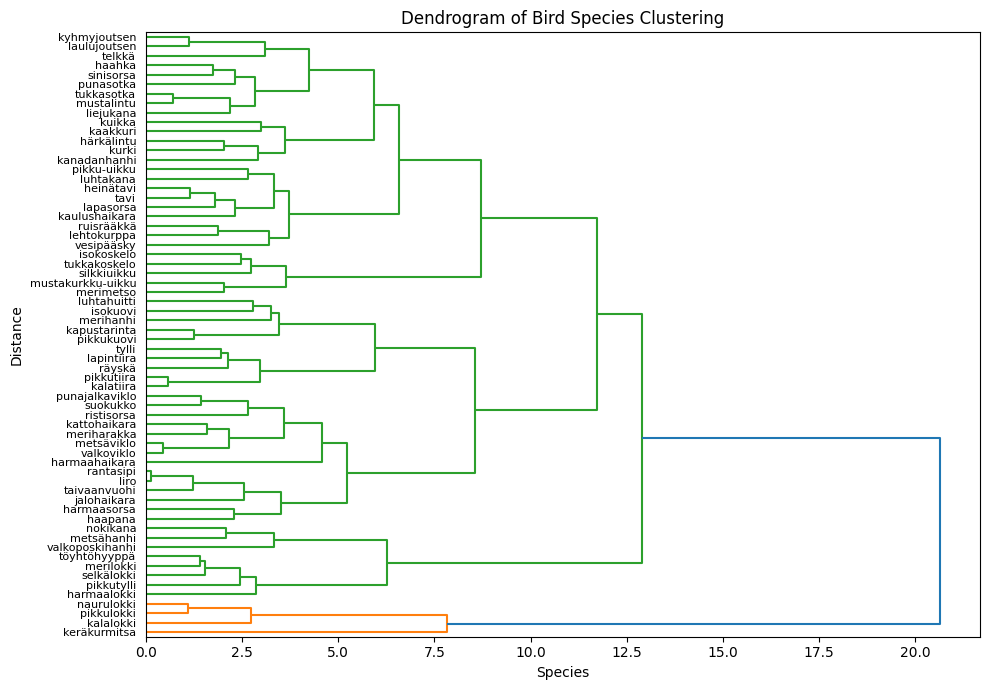

In [13]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

# Assuming you've already calculated the linkage matrix Z
# For demonstration, I'll use the 'complete' linkage method
Z = linkage(combined_dist, method='complete')

# Plotting the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z, labels=data['species'].values, leaf_rotation=0, leaf_font_size=8, orientation='right')
plt.title("Dendrogram of Bird Species Clustering")
plt.xlabel("Species")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()


To evaluate how well the clustering matches the biological grouping, we would need to visually inspect the dendrogram in relation to the provided taxonomy and also consider the normalized mutual information (NMI) values for different cluster numbers. However, based on the information provided and the taxonomy, here are some general observations and opinions:

Complexity of Biological Groupings: The taxonomy provided is hierarchical, with multiple levels of classification. This mirrors the nature of hierarchical clustering, which also provides a multi-level partitioning of the data. Ideally, the dendrogram should reflect similar groupings as the taxonomy.

Charadriiformes (shorebirds): This group has a more detailed sub-classification. If the clustering is effective, we should see clear distinctions, especially between the major subgroups like Lari and Charadrii. Within Lari, the gulls (Laridae) and terns (Sternidae) should ideally form distinct clusters.

Anatidae (ducks, geese, swans): This is another complex group. The distinction between dabbling ducks and diving ducks might be evident in the clustering if the features used for clustering capture these biological differences.

Gruiformes: This group has two distinct subgroups - cranes and rails. If the features are representative, these two should form separate clusters.

Singleton Groups: Groups like Phalacrocoracidae (cormorants), Podicipedidae (grebes), Gaviidae (loons), and Ardeidae (herons) are standalone in the taxonomy. If the clustering is effective, these should ideally form distinct clusters separate from the other groups.

Effectiveness of Features: The success of the clustering largely depends on the features used. The BMI and WSI might capture some biological differences, but the color features (back and belly) might introduce some noise, especially if different species have similar colors.

Differences Between Biological Groups: Some biological groups might be more distinct than others based on the features used. For instance, differences in size and weight might make some species (like swans) very distinct, while others with similar features might be harder to separate.